Largest Lyapunov exponent: 0.17468024617154676


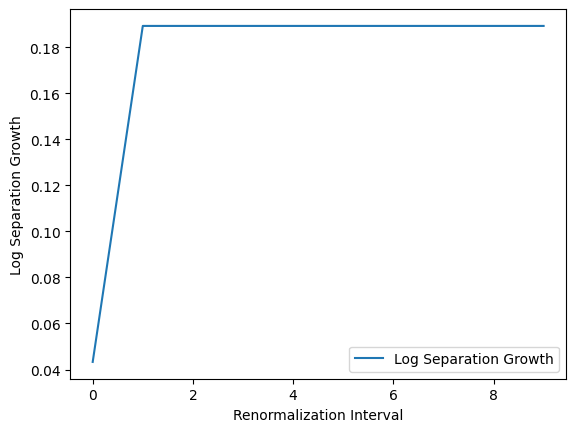

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Gravitational constant (normalized units)
G = 1

def three_body_eq(t, y, params):
    """
    Defines the equations of motion for the three-body problem.
    
    Parameters:
        t (float): Time variable (not used explicitly as the system is autonomous).
        y (ndarray): Array containing positions and velocities of the three bodies in the order:
                     [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
        params (tuple): Tuple containing (G, m1, m2, m3) where:
                        - G is the gravitational constant,
                        - m1, m2, m3 are the masses of the three bodies.
                        
    Returns:
        ndarray: Derivatives of positions and velocities in the same order as y.
    """
    G, m1, m2, m3 = params
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    
    # Compute distances
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    # Accelerations due to gravitational forces
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return np.array([vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3])

# Initial conditions and parameters
masses = (G, 1.0, 1.0, 1.0)  # Include G in parameters
y0 = np.array([0.9700436, -0.24308753, -0.9700436,  0.24308753, 0, 0,
               0.466203685, 0.43236573, 0.466203685, 0.43236573, -0.93240737, -0.86473146])

# Integration parameters
t_span = (0, 150)  # Shorter interval for each renormalization
t_eval = np.linspace(*t_span, 100)

# Perturbation and renormalization setup
perturbation = 1e-12
num_renormalizations = 10

# Initialize arrays to store separation growth
initial_perturbation = np.random.normal(scale=perturbation, size=6)  # Position perturbation
perturbed_y0 = np.concatenate([y0[:6] + initial_perturbation, y0[6:]])  # Perturbed positions

lyapunov_exponent_values = []

# Iterate for renormalizations
for i in range(num_renormalizations):
    # Integrate unperturbed and perturbed system for one interval
    sol_unperturbed = solve_ivp(three_body_eq, t_span, y0, args=(masses,), t_eval=t_eval, rtol=1e-10)
    sol_perturbed = solve_ivp(three_body_eq, t_span, perturbed_y0, args=(masses,), t_eval=t_eval, rtol=1e-10)
    
    # Calculate the separation at the end of the interval
    delta = sol_perturbed.y[:6, -1] - sol_unperturbed.y[:6, -1]
    final_separation = np.linalg.norm(delta)
    lyapunov_exponent_values.append(np.log(final_separation / perturbation) / (t_span[1] - t_span[0]))

    # Renormalize the separation
    delta_normalized = perturbation * delta / np.linalg.norm(delta)
    perturbed_y0 = np.concatenate([sol_unperturbed.y[:6, -1] + delta_normalized, sol_unperturbed.y[6:, -1]])

# Average Lyapunov exponent over intervals
lyapunov_exponent = np.mean(lyapunov_exponent_values)
print(f"Largest Lyapunov exponent: {lyapunov_exponent}")

# Plot the log separation over intervals
plt.plot(np.arange(num_renormalizations), lyapunov_exponent_values, label="Log Separation Growth")
plt.xlabel("Renormalization Interval")
plt.ylabel("Log Separation Growth")
plt.legend()
plt.show()


In [8]:
print(lyapunov_exponent_values)

[0.04330046359111006, 0.18927799979193877, 0.18927799979155235, 0.18927799979155235, 0.18927799979155235, 0.18927799979155235, 0.18927799979155235, 0.18927799979155235, 0.18927799979155235, 0.18927799979155235]
